# Breadth First Search

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using breadth first search


__BREADTH-FIRST-SEARCH__ ( _source_ , _destination_ ) __return__ a route   
&emsp;_frontier_ &larr; a **FIFO** initialized with _source_ node  
&emsp;_explored_ &larr; _empty_    
&emsp;_found_ &larr; _False_  
&emsp;__while__  _frontier_ __is not__ _empty_ __and__ _found_ __is__ _False_ __do__  
&emsp;&emsp;&emsp;_node_ &larr; _frontier_.pop()   
&emsp;&emsp;&emsp;__add__ _node_ __to__ _explored_    
&emsp;&emsp;&emsp;__for__ _child_ __in__ _node_.expand() __do__   
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ _child_ __is not in__ _explored_ __and__ _child_ __is not in__ _frontier_   __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; __if__ _child_ __is__ _destination_ __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; _route_ &larr; _child_.route()  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; _found_ &larr; _True_  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__add__ _child_ __to__ _frontier_    
&emsp;__return__  _route_

In [1]:
import osmnx as ox
import time
from tqdm import tqdm
from collections import deque
from utilities import *

Here OSMnx find the largest connected component centered around the ```location point``` with specified ```dist``` on each side (w/n/e/s).

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the osmid of the nodes for destination and source are 389677909, 55808290 respectively

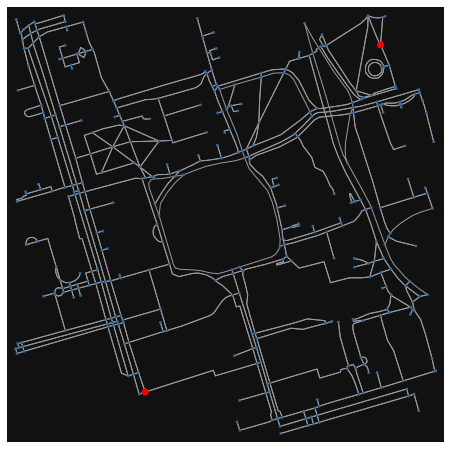

In [3]:
highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [4]:
draw_map(G, highlight = highlighted)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

Each node in our graph is represented as a dictionary with many attributes of no interest to us now, so manipulating them would obfuscate the algorithm jumping through hoops to get only one attribute from the dictionary. <b>so</b> we define class ```Node``` which only retains the data we need to be able to do searching and traversing, like the parent of the node (the one that produced it from its expansion) and the length of the edge between the parent and the node itself.

Please check its source code in ```./utilities/src/common.py``` to know how it captures the data from the graph. 

In [5]:
source(Node)

# The Algorithm

In [6]:
# first define the origin/source nodes as Node
origin = Node(graph = G, osmid = 55808290)
destination = Node(graph = G, osmid = 389677909)

In [7]:
bar = tqdm(total=len(G))

# this is where we would save our result at the end
route = []

# we will be using deque instead of normal python lists
# to have O(1) [pop/append]-ing instead of O(n) in lists
# because deques are implemented with linked-list and
# lists are implemented with arrays 

frontier = deque([origin])

# this is a directed multigraph so we need to have memory
# so we don't get stuck in a loop
explored = set()

found = False

while frontier and not found:
    bar.update(1); time.sleep(0.05) # for the progress bar -- ignore

    node = frontier.popleft()
    explored.add(node)
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route = child.path()
                found = True
            frontier.append(child)

bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost(G, route))

 61%|██████    | 230/379 [00:11<00:07, 19.50it/s]

The route is 

 [55808290, 304891685, 55808284, 1721866234, 389678268, 4953810915, 389678267, 24960090, 24960068, 1258698109, 389678145, 24960070, 24960073, 24960076, 24960080, 6028561924, 5098988924, 389678131, 2557539841, 389678133, 389677909] 

its cost is

 954.5749999999999


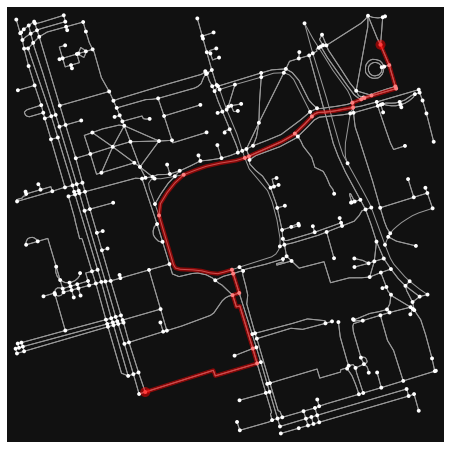

In [8]:
fig, ax = ox.plot_graph_route(G, route)

In [9]:
draw_route(G, route)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

We will be using uber's [kepler.gl](https://kepler.gl/) for one time in this notebook only to make you aware of it, but unfortunatley we won't be using it because of its of its limited API.

In [10]:
import pandas as pd
from keplergl import KeplerGl
import geopandas as gpd

In [11]:
map1 = KeplerGl(height=600, width=800)
map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(height=600)

Kepler is not integrated with osmnx so we need to build the GeoDataFrame of the route data by ourselves. And the above widget will change accordingly, so here we go.  

The is what we meant by limited API.

In [12]:
nodes, edges = ox.graph_to_gdfs(G)

First let's make a dataframe for the nodes of the route -- this dataframe need to have the y (latitude), x (longitude) of these nodes. That is done by filtering the nodes GeoDataFrame by only keeping the rows which have id in the route list. 

In [13]:
nodes

,y,x,osmid,highway,geometry
21631731,43.664082,-79.398444,21631731,traffic_signals,POINT (-79.39844 43.66408)
24959523,43.662431,-79.392864,24959523,NaN,POINT (-79.39286 43.66243)
24959549,43.662082,-79.397599,24959549,traffic_signals,POINT (-79.39760 43.66208)
24959556,43.660081,-79.398650,24959556,stop,POINT (-79.39865 43.66008)
24959559,43.660419,-79.396920,24959559,NaN,POINT (-79.39692 43.66042)
...,...,...,...,...,...
7311083157,43.661912,-79.396256,7311083157,NaN,POINT (-79.39626 43.66191)
7311083158,43.662335,-79.395821,7311083158,NaN,POINT (-79.39582 43.66234)
7866474269,43.660404,-79.396160,7866474269,NaN,POINT (-79.39616 43.66040)
7868892239,43.660408,-79.393026,7868892239,NaN,POINT (-79.39303 43.66041)


In [14]:
route_data_frame = nodes.loc[nodes.index.isin(route)]

We will need to load the dataframe into the map as what we will show in the next couple of cells, after that we need to use the GUI of the widget to add it manually.

In [15]:
route_data_frame

,y,x,osmid,highway,geometry
24960068,43.663027,-79.393493,24960068,NaN,POINT (-79.39349 43.66303)
24960070,43.662499,-79.394673,24960070,NaN,POINT (-79.39467 43.66250)
24960073,43.662285,-79.395750,24960073,NaN,POINT (-79.39575 43.66228)
24960076,43.661766,-79.396184,24960076,NaN,POINT (-79.39618 43.66177)
24960080,43.661075,-79.394901,24960080,NaN,POINT (-79.39490 43.66107)
24960090,43.663141,-79.392768,24960090,stop,POINT (-79.39277 43.66314)
55808284,43.663409,-79.392023,55808284,NaN,POINT (-79.39202 43.66341)
55808290,43.663941,-79.392284,55808290,NaN,POINT (-79.39228 43.66394)
304891685,43.663681,-79.392131,304891685,NaN,POINT (-79.39213 43.66368)
389677909,43.659518,-79.396428,389677909,NaN,POINT (-79.39643 43.65952)


In [16]:
map1.add_data(data=route_data_frame , name="route")

# if you run this cell again, it will fail
# that's what we meant when we said
# the binding of jupyter to JS is very primitive

Okay now we have update the widget with the nodes data frame and they should be displayed on the widget above now.

The hard part now is to make them connected and draw the lines.

What we have made above is called adding a layer to the visualization, and every layer need certain attributes to be rendered correctly.  

The "nodes" layers is called point layers which needs a dataframe consists of a rows of coordinates for each node/point to rendered. To display the route, we need use layer called "lines" layer which needs to have the source and destination coordinates for each line/road and after we add this dataframe, we need to add it manually.  

Let's get started

In [17]:
# let's build the dictionary from which
# we can convert it to pandas dataframe

# list of tuples (latitude, longitude)
src_nodes = []
dest_nodes = []

for src_node_edge, dest_node_edge in zip(route, route[1:]):
    
    src_nodes.append(
                    (
                     float(nodes.loc[[src_node_edge]]['x']),
                     float(nodes.loc[[src_node_edge]]['y'])
                    )
                   )
    
    dest_nodes.append(
                    (
                     float(nodes.loc[[dest_node_edge]]['x']),
                     float(nodes.loc[[dest_node_edge]]['y'])
                    )
                   )


In [18]:
data_frame = {
    'source_x' : [coordinates[0] for coordinates in src_nodes],
    'dest_x' :   [coordinates[0] for coordinates in dest_nodes],
    'source_y' : [coordinates[1] for coordinates in src_nodes],
    'dest_y' :   [coordinates[1] for coordinates in dest_nodes],
}

In [19]:
edges_route = pd.DataFrame(data_frame, columns = ['source_x', 'dest_x', 'source_y', 'dest_y'])


In [20]:
edges_route # y is latitude and x is longitude

,source_x,dest_x,source_y,dest_y
0,-79.392284,-79.392131,43.663941,43.663681
1,-79.392131,-79.392023,43.663681,43.663409
2,-79.392023,-79.392009,43.663409,43.663383
3,-79.392009,-79.392568,43.663383,43.663263
4,-79.392568,-79.392624,43.663263,43.663246
5,-79.392624,-79.392780,43.663246,43.663202
6,-79.392780,-79.392768,43.663202,43.663141
7,-79.392768,-79.393493,43.663141,43.663027
8,-79.393493,-79.393793,43.663027,43.662809
9,-79.393793,-79.394601,43.662809,43.662520


Okay let's have a clean map and add these lines step by step.

In [21]:
map2 = KeplerGl(height=600, width=800)
map2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(height=600)

In [22]:
map2.add_data(data=edges_route , name="route")

Okay now you need to press the little arrow icon on the upper left which opens a toolset to add layers, filters, and other things.

It should open on the "Layers" tab automatically, after that press **Add Layer** and name the layer anything and then from **Basic** dropbox choose **Line**, it will prompt you to specify Source Lat/Lng and Target Lat/Lng. Choose "source_y" in Source Lat and "source_x" in Source Lng, and then choose "dest_y" in Target Lat and "dest_x" in Target Lng.  

The "route" should be in its place now, to show it you need to scroll through the map of the world above to UofT coordinates and you should see the route in its place.

You can add another layer to see the nodes of the route in the same visualization by adding "Point" layer and remember that y is latitude and x in longitude.

---

This seems like a lot of hustle, but we wanted to introduce to you this tool because it is Uber :) and the project is [very active](https://github.com/keplergl/kepler.gl). 

The jupyter bindings are still primitive and needs a lot of work to be on par with leaflet-based maps, but the tool is originally intended to be a React Component and some people did some very slick visualization with it which you can check them on the kepler.gl website and [here](https://github.com/uber-web/kepler.gl-data). So keep this tool in mind when you are working on the next Uber :))